In [30]:
import numpy as np
import pandas as pd
import os
import re
import spacy
from spacy.lang.en import English
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
import pickle
from html.parser import HTMLParser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from collections import Counter

data_folder = "../input/"

emails = pd.read_csv(os.path.join(data_folder, 'emails.csv'))
questions = pd.read_csv(os.path.join(data_folder, 'questions.csv'))
matches = pd.read_csv(os.path.join(data_folder, 'matches.csv'))

profs = pd.read_csv(os.path.join(data_folder, 'professionals.csv'))
tag_users = pd.read_csv(os.path.join(data_folder, 'tag_users.csv'))
studs = pd.read_csv(os.path.join(data_folder, 'students.csv'))
tagq = pd.read_csv(os.path.join(data_folder, 'tag_questions.csv'))
groups = pd.read_csv(os.path.join(data_folder, 'groups.csv'))
emails = pd.read_csv(os.path.join(data_folder, 'emails.csv'))
groupm = pd.read_csv(os.path.join(data_folder, 'group_memberships.csv'))
answers = pd.read_csv(os.path.join(data_folder, 'answers.csv'))
comments = pd.read_csv(os.path.join(data_folder, 'comments.csv'))
matches = pd.read_csv(os.path.join(data_folder, 'matches.csv'))
tags = pd.read_csv(os.path.join(data_folder, 'tags.csv'))
questions = pd.read_csv(os.path.join(data_folder, 'questions.csv'))
school = pd.read_csv(os.path.join(data_folder, 'school_memberships.csv'))
hearts = pd.read_csv(os.path.join(data_folder, 'answer_scores.csv'))

**Exploratory Data Analysis**********

Professionals

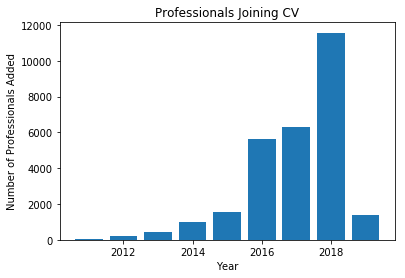

In [3]:
profs['professionals_date_joined'] = pd.to_datetime(profs['professionals_date_joined'])
profs['join_yr']=profs['professionals_date_joined'].dt.year
profsyr = profs[['join_yr','professionals_id']].groupby('join_yr').count().reset_index()

plt.bar(profsyr.join_yr, profsyr.professionals_id)

plt.xlabel('Year')
plt.ylabel('Number of Professionals Added')
plt.title('Professionals Joining CV')
plt.show()

In [4]:
profs['professionals_industry']=profs['professionals_industry'].fillna("")
profs['professionals_industry'] = profs['professionals_industry'].str.replace('healthcare','health care', flags=re.IGNORECASE, regex=True)
prof_ind = profs['professionals_industry'].tolist()
prof_ind=list(filter(lambda a: a != "", prof_ind))
prof_ind=list(filter(lambda a: a != "and", prof_ind))
prof_ind=list(filter(lambda a: a != "or", prof_ind))
prof_tokens=[]
for i in prof_ind:
    words = word_tokenize(i)
    words=[word.lower() for word in words if word.isalpha()]
    prof_tokens.append(words)
    
prof_tokens = [item for sublist in prof_tokens for item in sublist]
prof_tokens=list(filter(lambda a: a != "and", prof_tokens))
prof_tokens=list(filter(lambda a: a != "or", prof_tokens))

In [5]:
dic=dict(Counter(prof_tokens))
proft = pd.DataFrame.from_dict(dic, orient="index").reset_index()
proft.columns=['type','occur']
proft=proft.sort_values(by=['occur'], ascending=False)
proft.shape

(1182, 2)

There are 1182 professional industry topics. Let us take a look at the distribution.

Most Represented Professions

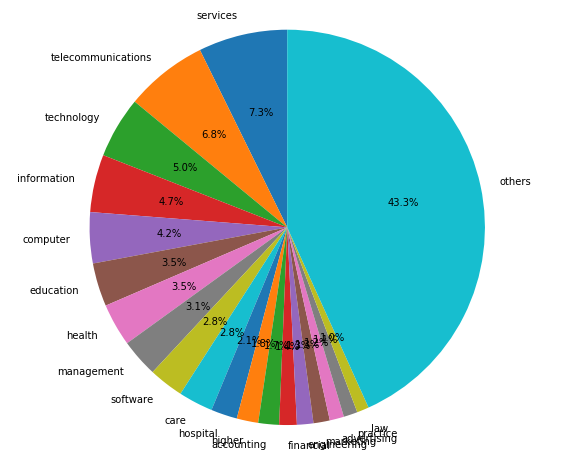

In [6]:
proftx=proft.type[:19].tolist()
proftx.append('others')
profty=proft.occur[:19].tolist()
profty.append(proft.occur.sum()-proft.occur[:19].sum())
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(profty, labels=proftx, autopct='%1.1f%%',startangle=90)
ax1.axis('equal')
plt.show()

Least Represented Professions

In [7]:
proft.tail(10)

,type,occur
688,kinesiology,1
700,horticulture,1
689,specializing,1
690,allied,1
692,associate,1
693,cre,1
697,preschool,1
698,pharmay,1
699,razavi,1
1181,ops,1


Let us try grouping similar words and reducing the number of industry topics.

In [8]:
proftlist=proft.type.tolist()
for i in range(len(proftlist)):
    for j in range(i+1, len(proftlist)):
        word1 = wn.synsets(proftlist[i], 'n')
        word2 = wn.synsets(proftlist[j], 'n')
        if (word1 and word2):
            if (word1[0].wup_similarity(word2[0])>0.95):
                proftlist[j]=proftlist[i]

In [9]:
proft.type=proftlist
proft = proft.groupby('type')['occur'].sum().reset_index()
proft.shape

(1079, 2)

In [10]:
ansauth=answers.groupby('answers_author_id')['answers_body'].count().reset_index()
profans = pd.merge(profs, ansauth, how="left", left_on='professionals_id', right_on='answers_author_id')
profans.shape, profans[~profans['answers_author_id'].isna()].shape

((28152, 8), (10067, 8))

There are 10,067 professionals who have not answered any questions.

In [11]:
noinfoauth = np.setdiff1d(answers.answers_author_id,profs.professionals_id)
noinfoauth.shape, answers[answers['answers_author_id'].isin(noinfoauth)].shape

((102,), (1017, 5))

Conversely, there are 102 answer authors who have added 1017 answers, but are not listed in the professionals database. Information about their professional affiliation has to be retrieved from analysing their previous answers.

Answers with Hearts

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


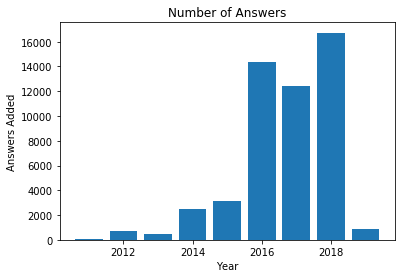

In [12]:
ans = answers[['answers_id','answers_date_added']]
ans['answers_date_added'] = pd.to_datetime(ans['answers_date_added'])
ans['year']=ans['answers_date_added'].dt.year
ans=ans.groupby('year')['answers_id'].count().reset_index()
plt.bar(ans.year, ans.answers_id)

plt.xlabel('Year')
plt.ylabel('Answers Added')
plt.title('Number of Answers')
plt.show()

In [13]:
hearts[hearts['score']!=0].shape

(13837, 2)

Out of a total of 51,138 answers, only 13837 or 27% have hearts.

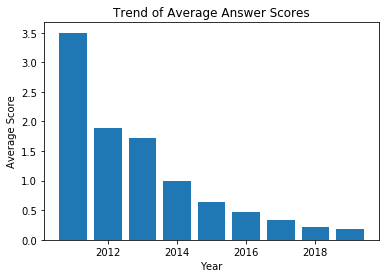

In [14]:
ansh = pd.merge(answers, hearts, how="left", left_on='answers_id', right_on='id')
ansh['answers_date_added'] = pd.to_datetime(ansh['answers_date_added'])
ansh['year']=ansh['answers_date_added'].dt.year
ansh = ansh.groupby('year')['score'].mean().reset_index()
plt.bar(ansh.year, ansh.score)

plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('Trend of Average Answer Scores')
plt.show()


**Emails**

Let us take a look at the maximum number of questions per email.

In [15]:
matches['matches_email_id'].value_counts().head()

569938    268
569892    266
569829    258
569941    253
508675    247
Name: matches_email_id, dtype: int64

In [16]:
maxq = matches[matches['matches_email_id']==569938]
maxq = pd.merge(maxq, questions, how="left", left_on=['matches_question_id'], right_on=['questions_id'])
maxq[['matches_email_id','questions_title','questions_body']].head()

,matches_email_id,questions_title,questions_body
0,569938,What is the best advice you can give an aspiri...,I'm not 100% sure I want to be a lawyer but I ...
1,569938,What aspect of college is the most challenging?,"As a student in 11th grade, I am currently thi..."
2,569938,What is the best way to spend the summer befor...,I would like to know some recommendations for ...
3,569938,"Is it possible to pursue a career in teaching,...",I'm the kind of person that wants to save the ...
4,569938,What are the best ways to get involved and pre...,I am going to be a freshman in college this fa...


A single email may have several unrelated questions, so a more targeted approach would have a better response rate.

Range of Response Times

In [17]:
fastans = answers.groupby('answers_question_id')['answers_date_added'].min().reset_index()
qatime=pd.merge(questions, fastans, how="left", left_on='questions_id', right_on='answers_question_id')
qatime['delta']=pd.to_datetime(qatime['answers_date_added']) -pd.to_datetime(qatime['questions_date_added'])
bin1=qatime[qatime['delta']<=pd.Timedelta('1 days')].shape[0]
bin2=qatime[qatime['delta']<=pd.Timedelta('3 days')].shape[0]-bin1
bin3=qatime[qatime['delta']<=pd.Timedelta('7 days')].shape[0]-bin2
bin4=qatime[qatime['delta']>pd.Timedelta('7 days')].shape[0]

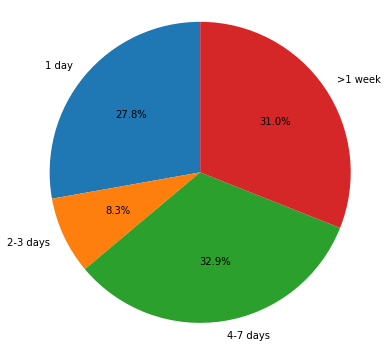

In [18]:
labels=['1 day','2-3 days','4-7 days','>1 week']
profty=[bin1, bin2, bin3, bin4]
fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(profty, labels=labels, autopct='%1.1f%%',startangle=90)
ax1.axis('equal')
plt.show()

**Recommendation System**

We will develop an LDA (Latent  Dirichlet allocation) on the entire corpus of 
* questions and answers, where each document will contain the question with all associated answers, as well as 
* all the answers given by an individual professional. 
This will give us better association between related terms.
We will extract the top topics, and any new question will be classified according to these topics. This will be matched against the professionals' data to get the most relevant professionals.

Functions for data cleaning

In [20]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def strip_html(s):
    s = s.replace("\n","")
    return re.sub(uri_re, ' ', str(s))

Merge questions title with body including tags. Merge all answers given for an individual question. Finally, merge the question with its answers.

In [31]:
questions['full_text'] = questions['questions_title'] +' '+ questions['questions_body']
questions['full_text'] = questions['full_text'].apply(strip_tags)
answers = answers[['answers_question_id','answers_body']]
answers['answers_body'] = answers['answers_body'].fillna("")
answers['answers_body'] = answers['answers_body'].apply(strip_tags)
answers['answers_per_q'] = answers.groupby('answers_question_id')['answers_body'].transform(lambda x: '.'.join(x))
ansrs=answers[['answers_question_id','answers_per_q']]
ansrs=ansrs.drop_duplicates()
qa = pd.merge(questions, ansrs, how="left", left_on='questions_id', right_on='answers_question_id')
qa['qa'] = qa['full_text'] +' '+ qa['answers_per_q']
qa['qa']=qa['qa'].fillna("")
qa=qa[~qa['answers_per_q'].isna()]

Next, we merge the answers given by each professional to create documents relevant to that professional.

In [21]:
answers = pd.read_csv(os.path.join(data_folder, 'answers.csv'))
answers['answers_body']=answers['answers_body'].fillna("")
answers['answers_body'] = answers['answers_body'].apply(strip_tags)

answers['proans']=answers.groupby('answers_author_id')['answers_body'].transform(lambda x: '.'.join(x))
answers=answers[['answers_author_id','proans']]
answers=answers.drop_duplicates()

We also merge the tags with the answers given by professionals for stronger topic correlations.

In [26]:
profans = pd.merge(profs, answers, how="left", left_on='professionals_id', right_on='answers_author_id')
tag_users = pd.read_csv(os.path.join(data_folder, 'tag_users.csv'))

tag_users=pd.merge(tag_users, tags, how="left", left_on='tag_users_tag_id', right_on='tags_tag_id')
tag_users['alltags']=tag_users.groupby('tag_users_user_id')['tags_tag_name'].transform(lambda x: '. '.join(x))
tag_users = tag_users[['tag_users_user_id','alltags']]
tag_users=tag_users.drop_duplicates()

profanstag = pd.merge(profans, tag_users, how="left", left_on='professionals_id', right_on='tag_users_user_id')
profanstag['allprof']=profanstag['proans']+' '+profanstag['alltags']
profanstag['allprof']=profanstag['allprof'].fillna("")

In [27]:
spacy.load('en')
stoplist=nltk.corpus.stopwords.words('english')
stoplist.append('school')
stoplist.append('college')
stoplist.append('career')
stoplist.append('degree')
stoplist.append('people')
stoplist.append('experience')
en_stop = set(stoplist)
def tokenize(text):
    lda_tokens = [token for token, pos in pos_tag(word_tokenize(text)) if pos.startswith('N')]
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

Our entire corpus will now include the questions+answers, and the professionals+answers.

In [39]:
fullcorp = qa['qa'].tolist()+profanstag['allprof'].tolist()

Tokenize the corpus and create the dictionary mapping.

In [40]:
text_data = []
for line in fullcorp:
    tokens = prepare_text_for_lda(line[:1000000])
    text_data.append(tokens)
    
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Run the LDA model to generate topics.

In [41]:
NUM_TOPICS = 30
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(5, '0.105*"teacher" + 0.051*"language" + 0.047*"student" + 0.035*"subject" + 0.034*"English"')
(21, '0.066*"photography" + 0.039*"photographer" + 0.032*"image" + 0.027*"camera" + 0.014*"space"')
(4, '0.074*"class" + 0.063*"course" + 0.050*"school" + 0.047*"student" + 0.046*"program"')
(1, '0.050*"construction" + 0.043*"architecture" + 0.035*"architect" + 0.030*"building" + 0.018*"Architecture"')
(18, '0.039*"field" + 0.029*"interest" + 0.028*"question" + 0.027*"years" + 0.024*"opportunity"')
(8, '0.036*"patient" + 0.035*"doctor" + 0.034*"hospital" + 0.034*"nurse" + 0.032*"nursing"')
(17, '0.143*"money" + 0.061*"loan" + 0.033*"student" + 0.032*"tuition" + 0.029*"income"')
(29, '0.092*"psychology" + 0.083*"sport" + 0.036*"Psychology" + 0.029*"therapy" + 0.028*"psychologist"')
(12, '0.093*"accounting" + 0.055*"business" + 0.047*"finance" + 0.021*"Accounting" + 0.020*"company"')
(14, '0.137*"design" + 0.069*"designer" + 0.047*"game" + 0.038*"artist" + 0.031*"portfolio"')
(15, '0.090*"tech

Get the topics for the documents in the entire corpus.

In [42]:
proftopics = ldamodel.get_document_topics(corpus)
topicdf = pd.DataFrame.from_records([{v:k for v, k in row} for row in proftopics])

Get the topics relevant to the professionals.

In [47]:
topicdf=topicdf.tail(profans.shape[0])

(51262, 30)

In [49]:
topicdf['prof_id']=profans['professionals_id']

((51262, 31),
           0                ...                                          prof_id
 0       NaN                ...                 9ced4ce7519049c0944147afb75a8ce3
 1  0.145389                ...                 f718dcf6d2ec4cb0a52a9db59d7f9e67
 2       NaN                ...                 0c673e046d824ec0ad0ebe012a0673e4
 3       NaN                ...                 977428d851b24183b223be0eb8619a8c
 4       NaN                ...                 e2d57e5041a44f489288397c9904c2b2
 
 [5 rows x 31 columns])

In [54]:
def getTopicForQuery (question):
    temp = question.lower()
    print (temp)

    words = re.findall(r'\w+', temp, flags = re.UNICODE )
    words=[word.lower() for word in words if word.isalpha()]

    important_words = []
    important_words = filter(lambda x: x not in stoplist, words)

    dictionary = corpora.Dictionary.load('dictionary.gensim')

    ques_vec = []
    ques_vec = dictionary.doc2bow(important_words)

    topic_vec = []
    topic_vec = ldamodel[ques_vec]

    word_count_array = np.empty((len(topic_vec), 2), dtype = np.object)
    for i in range(len(topic_vec)):
        word_count_array[i, 0] = topic_vec[i][0]
        word_count_array[i, 1] = topic_vec[i][1]

    idx = np.argsort(word_count_array[:, 1])
    idx = idx[::-1]
    word_count_array = word_count_array[idx]

    return word_count_array

For any given question, find the topics relevant to the question, and sort the professionals database by the topics to find the most relevant professionals.

In [58]:
question = 'What is the required education for airline pilots? #airline-industry'
topix_array = getTopicForQuery (question)
topix=[]
for each in topix_array:
    topix.append(each[0])

what is the required education for airline pilots? #airline-industry


In [64]:
topicdf=topicdf.sort_values(by=topix, ascending=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,prof_id
3197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033887,NaN,NaN,NaN,NaN,NaN,0.840708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016412,NaN,NaN,NaN,NaN,0.030051,NaN,0.062914,NaN,37c5c800e3934118aac2e7b020029123
4837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.806659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6a1b57081e7e46dabf5379be33f8f57a
10960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798820,NaN,NaN,NaN,NaN,0.067318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.102824,NaN,457637e8e4a74be8bee86f614f93e2fc
3384,NaN,NaN,0.04097,NaN,NaN,NaN,0.051422,0.062551,NaN,NaN,NaN,0.043425,NaN,0.728465,NaN,NaN,NaN,NaN,0.038068,NaN,NaN,NaN,NaN,NaN,NaN,0.024143,NaN,NaN,NaN,NaN,a5a64da2659e461699e3d97492058222
10838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050345,NaN,0.047772,NaN,0.021315,NaN,0.722961,NaN,NaN,NaN,NaN,0.018158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125436,NaN,29b1d7ac55714e1c9289dc511bc90120


The question can be sent to professionals with ids-

In [66]:
topicdf.head()['prof_id'].tolist()

['37c5c800e3934118aac2e7b020029123',
 '6a1b57081e7e46dabf5379be33f8f57a',
 '457637e8e4a74be8bee86f614f93e2fc',
 'a5a64da2659e461699e3d97492058222',
 '29b1d7ac55714e1c9289dc511bc90120']